In [5]:
from eodag import EODataAccessGateway, setup_logging
import pprint
import shutil
import os
import numpy as np
from osgeo import gdal, gdal_array, ogr, osr
import xarray as xr
from glob import glob
import requests
import json
from rasterio.enums import Resampling
import geopandas as gpd
from rasterio.features import geometry_mask
import rioxarray


# read data from dunia using eodag

In [6]:

setup_logging(3)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((8.715212 36.938467, 8.715212 36.942994, 8.724468 36.942994, 8.724468 36.938467, 8.715212 36.938467))"
search_results, total_count = dag.search(
    productType="S2_MSI_L2A",
    geom=geometry,
    start="2021-01-01",
    end="2022-12-31",
)


ContextualVersionConflict: (protobuf 4.25.1 (/home/eoafrica/.local/lib/python3.8/site-packages), Requirement.parse('protobuf<=3.20'), {'eodag-cube'})

In [3]:

my_result_paths = []
url = " http://datahub.creodias.eu/resto/api/collections/SENTINEL-2/search.json?startDate=2021-01-01&completionDate=2022-12-31&geometry=POLYGON ((8.7152 36.9385, 8.7152 36.9430, 8.7245 36.9430, 8.7245 36.9385, 8.7152 36.9385))&productType=S2MSI2A&maxRecords=20&page=1"
while True:
    print(url)
   
    # request
    resp = requests.get(url)
    response_json = json.loads(resp.text)
   
    # get next page
    next_link = [link["href"] for link in response_json["properties"]["links"] if link["rel"]=="next"]
    if len(next_link) == 1:
        url = next_link[0]
    else:
        break
   
    # get data path
    features = response_json["features"]
    for feature in features:
        data_path = "/home/eoafrica" + feature["properties"]["productIdentifier"]
        #if not os.path.exists(data_path):
            #raise Exception(f"Data {data_path} does not exist")
            
        if os.path.exists(data_path):
            my_result_paths.append(data_path)


 http://datahub.creodias.eu/resto/api/collections/SENTINEL-2/search.json?startDate=2021-01-01&completionDate=2022-12-31&geometry=POLYGON ((8.7152 36.9385, 8.7152 36.9430, 8.7245 36.9430, 8.7245 36.9385, 8.7152 36.9385))&productType=S2MSI2A&maxRecords=20&page=1
https://datahub.creodias.eu/resto/api/collections/SENTINEL-2/search.json?startDate=2021-01-01&completionDate=2022-12-31&geometry=POLYGON+%28%288.7152+36.9385%2C+8.7152+36.9430%2C+8.7245+36.9430%2C+8.7245+36.9385%2C+8.7152+36.9385%29%29&productType=S2MSI2A&maxRecords=20&page=2
https://datahub.creodias.eu/resto/api/collections/SENTINEL-2/search.json?startDate=2021-01-01&completionDate=2022-12-31&geometry=POLYGON+%28%288.7152+36.9385%2C+8.7152+36.9430%2C+8.7245+36.9430%2C+8.7245+36.9385%2C+8.7152+36.9385%29%29&productType=S2MSI2A&maxRecords=20&page=3
https://datahub.creodias.eu/resto/api/collections/SENTINEL-2/search.json?startDate=2021-01-01&completionDate=2022-12-31&geometry=POLYGON+%28%288.7152+36.9385%2C+8.7152+36.9430%2C+8.7245

In [4]:
len(my_result_paths)


220

In [5]:
sorted_paths = sorted(my_result_paths)


# extract roi region 

In [6]:
import geopandas as gpd
from shapely import wkt
# WKT representation of the polygon
geometry_wkt = geometry
# Create a GeoDataFrame with the WKT geometry
geometry = wkt.loads(geometry_wkt)
gdf = gpd.GeoDataFrame(geometry=[geometry])
# Set the CRS to WGS84 (EPSG:4326)
gdf.crs = "EPSG:4326"
# Save the GeoDataFrame to a shapefile
gdf.to_file('/home/eoafrica/Products/download/AOI.shp', driver="ESRI Shapefile")

NameError: name 'geometry' is not defined

# extract ndvi for one sentinel image

In [7]:
def access_bands_path(image_path):
    
    image_bands = os.path.join(image_path, 'GRANULE')
    files2 = os.listdir(image_bands)
    for file in files2:
        bands_path=os.path.join(image_bands, file ,'IMG_DATA','R10m')
    return(bands_path)

In [8]:
def extract_ndvi_bands(final_bands):
    final=os.listdir(final_bands)
    for i in range(len(final)):
        if "B04" in final[i]:
            file_red=final[i]
        if "B08" in final[i]:
            file_IR=final[i]           

    # Create full path to files
    product_IR = os.path.join(final_bands, file_IR)
    product_red = os.path.join(final_bands, file_red)
    return product_IR , product_red 

In [9]:
def calculate_NDVI(product_red, product_IR,aoi,date):
    red =rioxarray.open_rasterio(product_red)
    nir = rioxarray.open_rasterio(product_IR )
    red["band"] = ["red"]
    nir["band"] = ["nir"]
    data_array = xr.concat([red, nir], dim="band")
    NDVI = (data_array.sel(band="nir") - data_array.sel(band="red")*1.) / (
    data_array.sel(band="nir") + data_array.sel(band="red"))
    NDVI = NDVI.fillna(-1)
    #NDVI = NDVI.rio.write_crs('EPSG:32632')
    data_reprojected = NDVI.rio.reproject('EPSG:4326', resampling=Resampling.bilinear, nodata=np.nan, )
    clipped_ds = data_reprojected.rio.clip(aoi.geometry)
    clipped_ds.name = date
    ndvi_dataset = clipped_ds.to_dataframe()
    return ndvi_dataset


# extract NDVI time series from all images 

In [65]:
import pandas as pd
from functools import reduce

def merge_two_dfs(left, right):
    return pd.merge(left, right, on=['x','y'])

we have extracted ndvi file by batch due to pb with kernel stopping and we have saved different csv file that will be merged in next step

In [80]:
shapefile_path = '/home/eoafrica/Products/download/AOI.shp'
aoi = gpd.read_file(shapefile_path)
i=0
List_ndvi=[]
for x in sorted_paths[190:221]:
    print(x)
    name=x.split("_")[3]
    date=name[:8]
    final_bands=access_bands_path(x)
    product_IR , product_red=extract_ndvi_bands(final_bands)
    ndvi=calculate_NDVI(product_red, product_IR,aoi,date)
    ndvi= ndvi.drop('spatial_ref', axis=1)
    List_ndvi.append(ndvi)
    del product_IR
    del product_red
    del ndvi



/home/eoafrica/eodata/Sentinel-2/MSI/L2A_N0500/2021/08/01/S2A_MSIL2A_20210801T101031_N0500_R022_T32SMF_20230116T173103.SAFE
/home/eoafrica/eodata/Sentinel-2/MSI/L2A_N0500/2021/08/06/S2B_MSIL2A_20210806T100559_N0500_R022_T32SMF_20230211T085202.SAFE
/home/eoafrica/eodata/Sentinel-2/MSI/L2A_N0500/2021/08/11/S2A_MSIL2A_20210811T101031_N0500_R022_T32SMF_20230212T045253.SAFE
/home/eoafrica/eodata/Sentinel-2/MSI/L2A_N0500/2021/08/16/S2B_MSIL2A_20210816T100559_N0500_R022_T32SMF_20230213T154819.SAFE
/home/eoafrica/eodata/Sentinel-2/MSI/L2A_N0500/2021/08/21/S2A_MSIL2A_20210821T101031_N0500_R022_T32SMF_20230121T135342.SAFE
/home/eoafrica/eodata/Sentinel-2/MSI/L2A_N0500/2021/08/26/S2B_MSIL2A_20210826T100549_N0500_R022_T32SMF_20230218T042507.SAFE
/home/eoafrica/eodata/Sentinel-2/MSI/L2A_N0500/2021/08/31/S2A_MSIL2A_20210831T101031_N0500_R022_T32SMF_20230207T134345.SAFE
/home/eoafrica/eodata/Sentinel-2/MSI/L2A_N0500/2021/09/05/S2B_MSIL2A_20210905T100549_N0500_R022_T32SMF_20230118T082625.SAFE
/home/eo

In [81]:
# Use reduce to merge all DataFrames in the list
merged_df = reduce(merge_two_dfs, List_ndvi)

# Print the merged DataFrame
#print(merged_df)

In [82]:
merged_df.to_csv('/home/eoafrica/Products/download/12_ndvif190-122.csv')

In [96]:
import pandas as pd
import fnmatch
def combine_multiple_csv(input_folder, dst_file,template_file, extension='*.csv'):
    files_list = os.listdir(input_folder)
    files_list =sorted(files_list)
    dfs = []
    lat_lon_df = pd.read_csv(template_file, header=None)
    lat_lon_df = lat_lon_df.loc[:, :1]
    for item in files_list:
        if ".ipynb" not in item:
            if fnmatch.fnmatch(item,extension):
                print(item)
                df = pd.read_csv(input_folder +'/'+ item, header=None)
                df = df.loc[:, 2:]
                #df.columns = [item[1:9]]
                dfs.append(df)
                df=None
    
    merged_df  = pd.concat(dfs, axis=1)
    out_df = pd.concat([lat_lon_df, merged_df ], axis=1)
    out_df.to_csv(dst_file, index=None, header=None)

In [97]:
combine_multiple_csv('/home/eoafrica/Products/download/ndvi_csv','/home/eoafrica/Products/download/ndvi_csv/final.csv','/home/eoafrica/Products/download/ndvi_csv/1ndvif1-5.csv')

1ndvif1-5.csv
2ndvif5-10.csv
3_ndvif10-15.csv
4_ndvif15-20.csv
5_ndvif20-30.csv
6_ndvif30-40.csv
7_ndvif40-60.csv
8_ndvif60-80.csv
ndvif090_120.csv
ndvif120_150.csv
ndvif150_190.csv
ndvif190_122.csv


In [91]:
input_folder='/home/eoafrica/Products/download/ndvi_csv'
a=os.listdir(input_folder)
sorted(a)


['.ipynb_checkpoints',
 '1ndvif1-5.csv',
 '2ndvif5-10.csv',
 '3_ndvif10-15.csv',
 '4_ndvif15-20.csv',
 '5_ndvif20-30.csv',
 '6_ndvif30-40.csv',
 '7_ndvif40-60.csv',
 '8_ndvif60-80.csv',
 'ndvif090_120.csv',
 'ndvif120_150.csv',
 'ndvif150_190.csv',
 'ndvif190_122.csv']

# wavelet decomposition for one time series 


In [117]:
!pip install pymannkendall

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import pandas as pd
x=pd.read_csv('/home/eoafrica/Products/download/ndvi_csv/final.csv')
x

,x,y,20210103.0,20210108.0,20210113.0,20210118.0,20210123.0,20210128.0,20210202.0,20210207.0,...,20211114.0.1,20211119.0.1,20211124.0.1,20211129.0.1,20211204.0.1,20211209.0.1,20211214.0.1,20211219.0.1,20211224.0.1,20211229.0.1
0,8.715286,36.942972,0.866973,0.414998,0.045754,0.501921,0.802197,-0.020598,0.003662,0.011640,...,-0.009008,0.042037,0.413135,0.014828,0.113633,0.082580,0.438523,0.127415,0.428976,0.090244
1,8.715388,36.942972,0.876651,0.424909,0.030385,0.515995,0.802399,-0.018294,-0.005508,0.011592,...,-0.010367,0.042673,0.428360,0.013305,0.105625,0.098546,0.434410,0.118254,0.438082,0.103108
2,8.715489,36.942972,0.871484,0.430441,0.020339,0.537015,0.813602,-0.017462,-0.011152,0.011388,...,-0.006885,0.042892,0.431201,0.018610,0.110312,0.121202,0.443494,0.112749,0.451177,0.105518
3,8.715591,36.942972,0.884042,0.414349,0.015465,0.532051,0.812329,-0.018844,-0.013516,0.015015,...,-0.009025,0.042010,0.398763,0.014833,0.115272,0.138558,0.420790,0.121298,0.424896,0.110912
4,8.715692,36.942972,0.891996,0.406900,0.016618,0.541431,0.809965,-0.020909,0.028641,0.011009,...,-0.008134,0.033888,0.413665,0.019776,0.112276,0.157848,0.407703,0.110518,0.426080,0.154621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,8.724026,36.938500,0.871541,0.469890,-0.041635,0.116618,0.810353,-0.036499,0.012684,-0.014938,...,0.006256,0.070212,0.470106,0.019845,0.273554,0.172188,0.477148,0.132668,0.475994,0.024881
4091,8.724128,36.938500,0.875128,0.473103,-0.044564,0.102916,0.824341,-0.029362,0.002595,-0.015469,...,0.005224,0.065543,0.471562,0.019964,0.280512,0.184125,0.480139,0.170431,0.482605,0.022345
4092,8.724229,36.938500,0.883379,0.475719,-0.045336,0.101482,0.830937,-0.023860,0.001338,-0.011391,...,-0.000864,0.052662,0.480306,0.019411,0.281201,0.200063,0.499578,0.180185,0.485790,0.021095
4093,8.724331,36.938500,0.870996,0.465088,-0.040040,0.099955,0.818055,-0.025723,-0.004854,-0.008134,...,-0.000129,0.046641,0.480231,0.016902,0.278376,0.207848,0.493792,0.176589,0.488457,0.030177


In [9]:
df=x
header = df.columns.tolist()


In [10]:
new_list=[]
final_list=[]

for x in header:
    if '_y'  not in x :
        new_list.append(x)
for z in new_list:
    if '_x.1'  not in z :
        final_list.append(z)
len(final_list)

201

In [12]:
df_filtered = df[final_list]

In [13]:
df_filtered

,x,y,20210103.0,20210108.0,20210113.0,20210118.0,20210123.0,20210128.0,20210202.0,20210207.0,...,20211114.0.1,20211119.0.1,20211124.0.1,20211129.0.1,20211204.0.1,20211209.0.1,20211214.0.1,20211219.0.1,20211224.0.1,20211229.0.1
0,8.715286,36.942972,0.866973,0.414998,0.045754,0.501921,0.802197,-0.020598,0.003662,0.011640,...,-0.009008,0.042037,0.413135,0.014828,0.113633,0.082580,0.438523,0.127415,0.428976,0.090244
1,8.715388,36.942972,0.876651,0.424909,0.030385,0.515995,0.802399,-0.018294,-0.005508,0.011592,...,-0.010367,0.042673,0.428360,0.013305,0.105625,0.098546,0.434410,0.118254,0.438082,0.103108
2,8.715489,36.942972,0.871484,0.430441,0.020339,0.537015,0.813602,-0.017462,-0.011152,0.011388,...,-0.006885,0.042892,0.431201,0.018610,0.110312,0.121202,0.443494,0.112749,0.451177,0.105518
3,8.715591,36.942972,0.884042,0.414349,0.015465,0.532051,0.812329,-0.018844,-0.013516,0.015015,...,-0.009025,0.042010,0.398763,0.014833,0.115272,0.138558,0.420790,0.121298,0.424896,0.110912
4,8.715692,36.942972,0.891996,0.406900,0.016618,0.541431,0.809965,-0.020909,0.028641,0.011009,...,-0.008134,0.033888,0.413665,0.019776,0.112276,0.157848,0.407703,0.110518,0.426080,0.154621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,8.724026,36.938500,0.871541,0.469890,-0.041635,0.116618,0.810353,-0.036499,0.012684,-0.014938,...,0.006256,0.070212,0.470106,0.019845,0.273554,0.172188,0.477148,0.132668,0.475994,0.024881
4091,8.724128,36.938500,0.875128,0.473103,-0.044564,0.102916,0.824341,-0.029362,0.002595,-0.015469,...,0.005224,0.065543,0.471562,0.019964,0.280512,0.184125,0.480139,0.170431,0.482605,0.022345
4092,8.724229,36.938500,0.883379,0.475719,-0.045336,0.101482,0.830937,-0.023860,0.001338,-0.011391,...,-0.000864,0.052662,0.480306,0.019411,0.281201,0.200063,0.499578,0.180185,0.485790,0.021095
4093,8.724331,36.938500,0.870996,0.465088,-0.040040,0.099955,0.818055,-0.025723,-0.004854,-0.008134,...,-0.000129,0.046641,0.480231,0.016902,0.278376,0.207848,0.493792,0.176589,0.488457,0.030177


plot any time series obtained

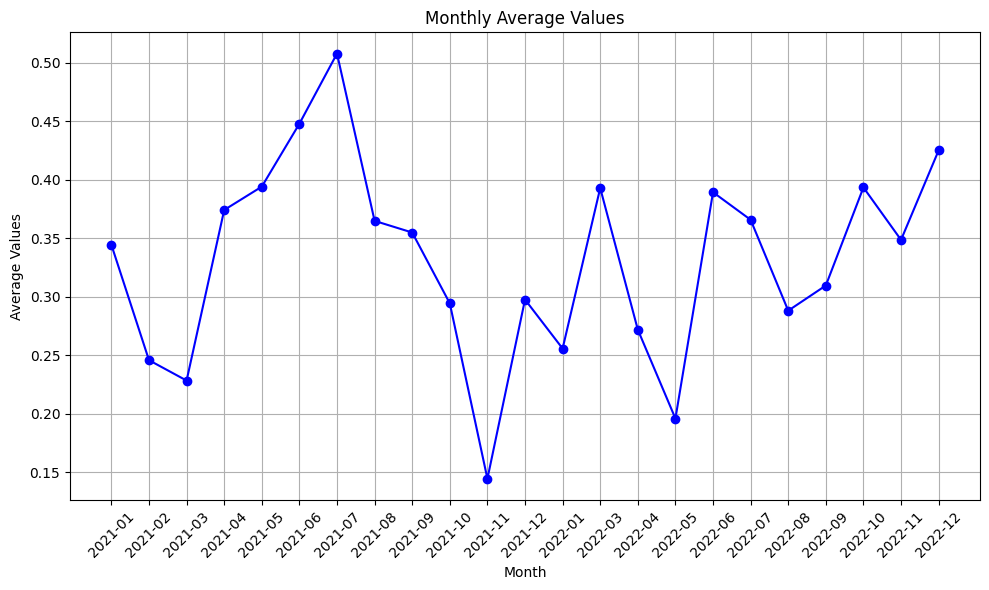

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
selected_ts=0
# Load the CSV file into a DataFrame
df = df_filtered

# Extract the dates and corresponding values for the first row
dates = df.columns[2:]
values = df.iloc[selected_ts, 2:].astype(float)

# Extract only the first 6 characters (year and month) from the date column
dates = dates.str[:6]

# Convert the dates to datetime objects
dates = pd.to_datetime(dates, format='%Y%m', errors='coerce')

# Aggregate values by month
monthly_values = values.groupby(dates.to_period("M")).mean()

# Plot the chronological graph
plt.figure(figsize=(10, 6))
plt.plot(monthly_values.index.astype(str), monthly_values.values, marker='o', linestyle='-', color='b')
plt.title('Monthly Average Values')
plt.xlabel('Month')
plt.ylabel('Average Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


extract ndvi ts

In [16]:
pixel_num=0
ndvi=df.iloc[pixel_num, 2:]


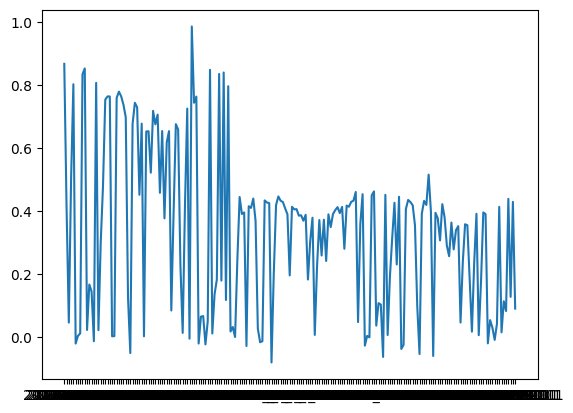

In [25]:
plt.plot(ndvi)

In [17]:
def remove_outliers(ts):
    ts_corrected = ts.copy()
    per = 10/100

    for j in range(1, len(ts_corrected) - 1):
        if (ts[j]-ts[j-1]<-per*ts[j-1]) and (ts[j]-ts[j+1]<-per*ts[j+1]):
            ts_corrected[j] = (ts[j-1]+ts[j+1])/2

    return ts_corrected

In [18]:
ndvif=remove_outliers(ndvi)
ndvif.to_csv('/home/eoafrica/Products/download/ndvi_csv/ndvits.csv', index=None, header=None)

20210103.0      0.866973
20210108.0      0.414998
20210113.0      0.458460
20210118.0      0.501921
20210123.0      0.802197
                  ...   
20211209.0.1    0.276078
20211214.0.1    0.438523
20211219.0.1    0.433749
20211224.0.1    0.428976
20211229.0.1    0.090244
Name: 0, Length: 199, dtype: float64

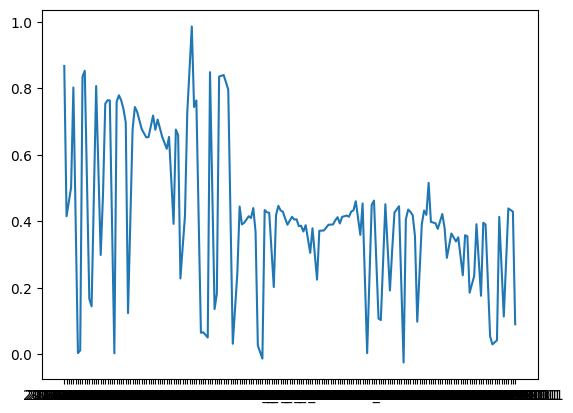

In [29]:
plt.plot(ndvif)

In [30]:
import pywt
# Perform multi-resolution wavelet decomposition up to level 5 with 'sym12' wavelet
coeffs = pywt.wavedec(ndvif, 'sym12', level=5)

# Reconstruct the approximation at level 5 (equivalent to a5 in MATLAB)
a5 = pywt.waverec(coeffs[:-1] + [None], 'sym12')



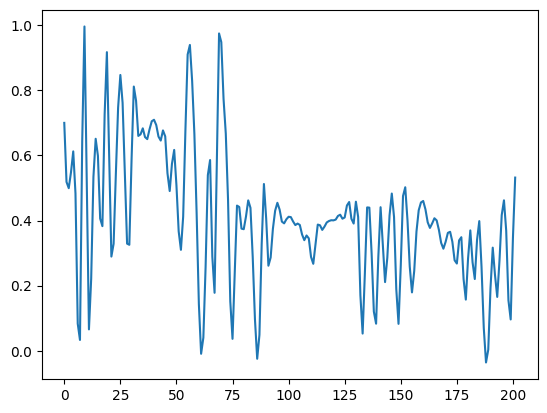

In [31]:
plt.plot(a5)

In [23]:
import pymannkendall as mk

# Data generation for analysis
trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(a5)

In [33]:
slope

-0.0016588824446672485

# forecast ndvi ts using LSTM


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from sklearn.metrics import mean_squared_error

In [36]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


In [42]:
dataframe = pd.read_csv('/home/eoafrica/Products/download/ndvi_csv/ndvits.csv',engine='python',header=None)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [43]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
trainc, testc = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(trainc), len(testc))

159 40


In [44]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	# look_back: the number of previous time steps to use as input variables to predict the next time period
	# if you want to predict current passenger # based on two time stamps back, look_back should be 2
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [66]:
# reshape into X=t and Y=t+1
n_input = 1   
n_features = 1      # number of input variables used for forecast (here, only 1 i.e. temperature)

look_back = 1
trainXc, trainYc = create_dataset(trainc, look_back)
testXc, testYc = create_dataset(testc, look_back)
# reshape input to be [samples, time steps, features]
trainXc = np.reshape(trainXc, (trainXc.shape[0], 1, trainXc.shape[1]))
testXc = np.reshape(testXc, (testXc.shape[0], 1, testXc.shape[1]))

modelc = Sequential()
modelc.add(InputLayer((n_input,n_features)))
modelc.add(LSTM(150)) #30
modelc.add(Dense(1))
modelc.summary()    
#early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)
modelc.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics = RootMeanSquaredError())
#model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, callbacks = [early_stop])
modelc.fit(trainXc, trainYc, validation_data = (testXc, testYc), epochs = 300) 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 150)               91200     
                                                                 
 dense_5 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
5/5 [==============================] - 2s 81ms/step - loss: 0.2398 - root_mean_squared_error: 0.4897 - val_loss: 0.0934 - val_root_mean_squared_error: 0.3056
Epoch 2/300
5/5 [==============================] - 0s 8ms/step - loss: 0.2092 - root_mean_squared_error: 0.4574 - val_loss: 0.0763 - val_root_mean_squared_error: 0.2763
Epoch 3/300
5/5 [==============================] - 0s 8ms/step - loss: 0.

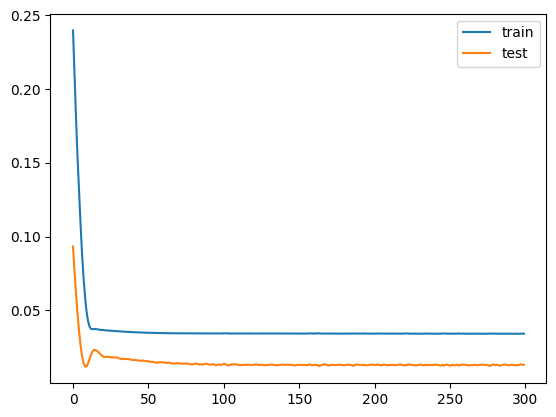

In [67]:
# plot history
plt.plot(modelc.history.history['loss'], label='train')
plt.plot(modelc.history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [68]:
predtrain = modelc.predict(trainXc)
predtest = modelc.predict(testXc)

2/2 [==============================] - 0s 2ms/step


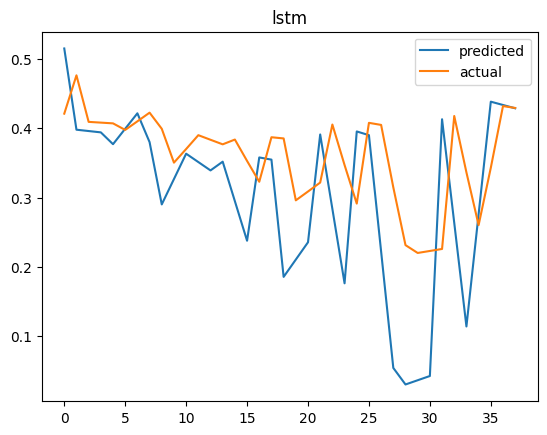

In [69]:
plt.plot(testYc)
plt.plot(predtest)
plt.title('lstm')
plt.legend(['predicted', 'actual'])
plt.show()

In [70]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from numpy import sqrt 
from sklearn.metrics import r2_score
import statistics
rmse = sqrt(mean_squared_error(testYc, predtest))
mae=mean_absolute_error(testYc, predtest)
nrmse= rmse/ (max(testYc) - min(testYc))
print(rmse, mae, nrmse)
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
print(MAPE(testYc,predtest))
r2 = r2_score(testYc,predtest)
print(r2)

0.11447095 0.08783428 0.23572257
118.36233139038086
0.138762722787382
